In [46]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import argparse
from collections import OrderedDict

import yaml
import csv
import time
from datetime import datetime
import shutil
import logging
from typing import Tuple, Sequence, Any, Union
from functools import partial

from jax import random
import jax.numpy as jnp
import jax
from brax.io import html
from brax import jumpy as jp
from brax import envs
from IPython.display import HTML

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import evojax
from evojax.util import get_params_format_fn
from evojax.task.base import TaskState
from evojax.policy.base import PolicyState
from evojax.policy.base import PolicyNetwork
from flax.struct import dataclass
from flax import linen as nn

from evojax.task.brax_task import BraxTask
from evojax.task.gym_task import Gym
from evojax.algo import PGPE, OpenES
from evojax import ObsNormalizer
from evojax import SimManager

sns.set_style('darkgrid')
sns.set_palette('muted', desat=.6)
sns.set_context("notebook", font_scale=1.0,
                rc={"lines.linewidth": 2.5})

output_dir = '/home/floyed/evojax/examples/metaplasticity_plot/injury'

In [2]:
def load_model(model_dir: str) -> Tuple[np.ndarray, np.ndarray, int, float, int]:
    model_file = os.path.join(model_dir, 'best.npz')
    if not os.path.exists(model_file):
        raise ValueError('Model file {} does not exist.')
    with np.load(model_file, allow_pickle=True) as data:
        params = data['params']
        obs_params = data['obs_params']
        epoch = data.get('epoch', 0)
        score = data.get('score', -float('Inf'))
        steps = data.get('steps', 0)
    return params, obs_params, epoch, score, steps

### Eval with injury

In [3]:
def eval_with_injury(policy, env_name, obs_normalizer, params, obs_params, target=None, injury=False, plot=True):
    # def step_once(carry, input_data):
    #     (task_state, policy_state, params, obs_params,
    #      accumulated_reward) = carry
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
    #     act, policy_state = act_fn(task_state, params[None, :], policy_state)
    #     task_state = task_state.replace(obs=task_state.obs[0])
    #     task_state = env.step(task_state, act[0])
    #     policy_state = update_fn(params[None, :], policy_state, None)
    #     accumulated_reward = accumulated_reward + task_state.reward
    #
    #     return ((task_state, policy_state, params, obs_params, accumulated_reward), (task_state))
    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    rng = jax.random.PRNGKey(42 + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)

    # accumulated_rewards = jnp.zeros((1, ))
    # task_states = jax.lax.scan(
    #     step_once,
    #     (task_state, policy_state, params, obs_params, accumulated_rewards),
    #     (), 1000
    # )
    # print(task_states)

    step = 0
    while not task_state.done:
        rollout.append(task_state)
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.
        if step > 500 and step < 550 and injury:
            policy_state.fast_Ws[1] *= 0

        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = step_fn(task_state, act[0])
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws') and step % 10 == 0:
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    if plot:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = np.array(jnp.concatenate(w)[jnp.newaxis, :, jnp.newaxis, :, :])
            # TODO: w

        html.save_html(os.path.join(output_dir, 'eval_with_injury_{}.html'.format(target)), env.sys, [s.qp for s in rollout])

        fig, ax = plt.subplots()
        ax.plot(rewards)
        plt.savefig(os.path.join(output_dir, 'BraxMetaLearning_{}.pdf').format(target))

    return rewards, rollout

#### Meta

In [34]:
env = 'swimmer_dir'  # ur5e  fetch  swimmer_dir  halfcheetah_vel  ant_dir
num_tasks = 8
hidden_dims = [128]
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230620-213437'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230614-220747'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-halfcheetah_vel-ABCD-20230622-192203'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-hopper_vel-ABCD-20230622-192225'
resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230624-095727'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-fetch-ABCD-20230622-212210'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ur5e-ABCD-20230622-192216'
# resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230622-192221'

train_task = BraxTask(
    env_name=env,
    test=False,
    num_tasks=num_tasks
    # terminate_when_unhealthy=args.terminate_when_unhealthy
)
policy = getattr(evojax.policy, 'MetaStdpMLPPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume)
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

(9,) (2,)
(9,)


0 / 12
(1, 1) (1, 8)
[Eval with injury] 100, reward:2.051e+01
[Eval with injury] 200, reward:4.198e+01
[Eval with injury] 300, reward:6.245e+01
[Eval with injury] 400, reward:8.691e+01
[Eval with injury] 500, reward:1.166e+02
[Eval with injury] 600, reward:1.547e+02
[Eval with injury] 700, reward:2.066e+02
[Eval with injury] 800, reward:2.753e+02
[Eval with injury] 900, reward:3.384e+02
[Eval with injury] 1000, reward:3.689e+02
[Eval with injury] rollout reward = 368.9356689453125
1 / 12
(1, 1) (1, 8)
[Eval with injury] 100, reward:5.223e+01
[Eval with injury] 200, reward:1.489e+02
[Eval with injury] 300, reward:1.791e+02
[Eval with injury] 400, reward:2.211e+02
[Eval with injury] 500, reward:2.920e+02
[Eval with injury] 600, reward:4.652e+02
[Eval with injury] 700, reward:8.449e+02
[Eval with injury] 800, reward:1.562e+03
[Eval with injury] 900, reward:2.702e+03
[Eval with injury] 1000, reward:4.233e+03
[Eval with injury] rollout reward = 4232.88037109375
2 / 12
(1, 1) (1, 8)
[Eval wi

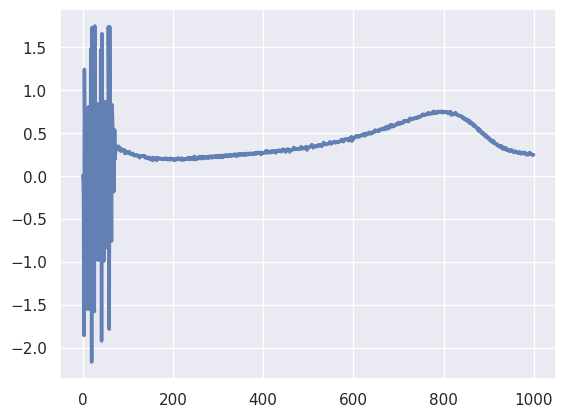

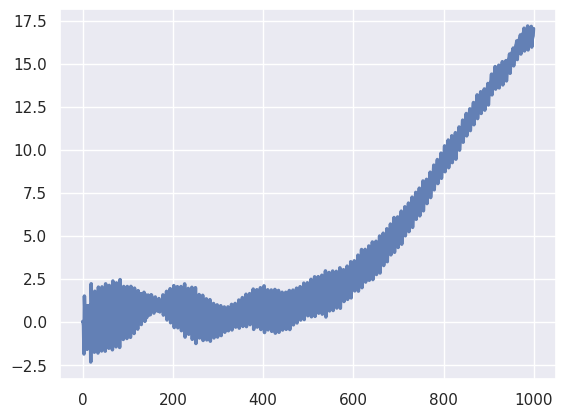

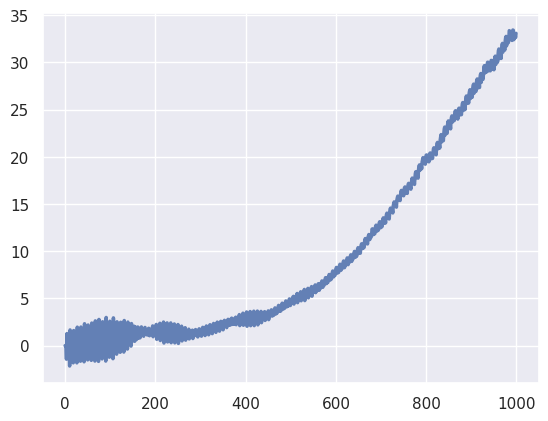

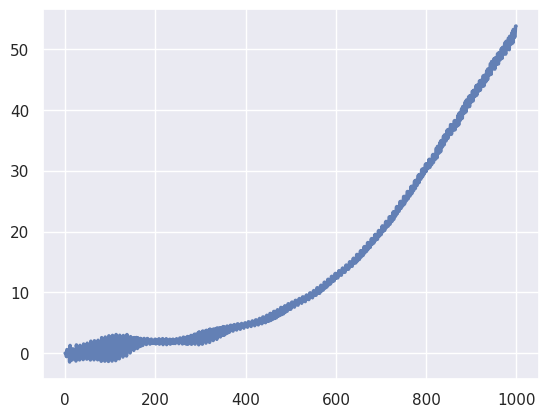

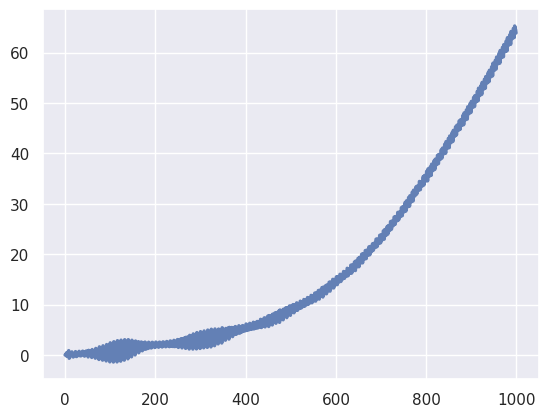

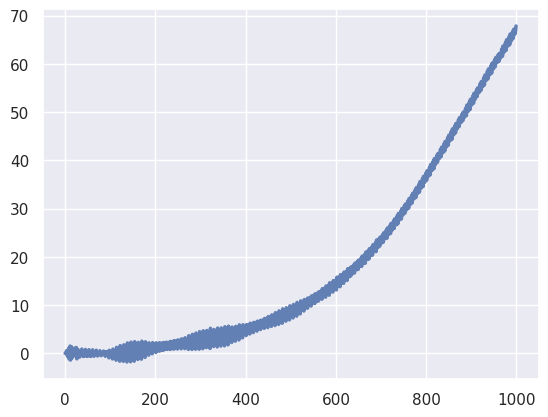

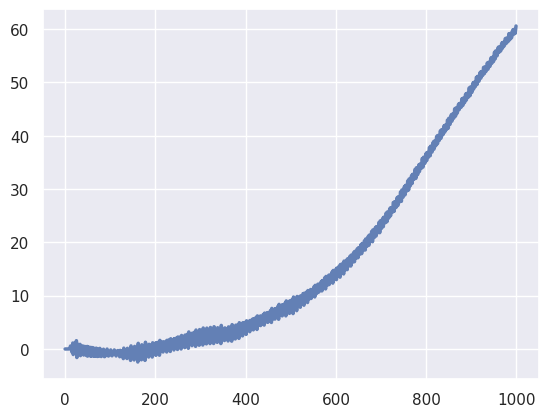

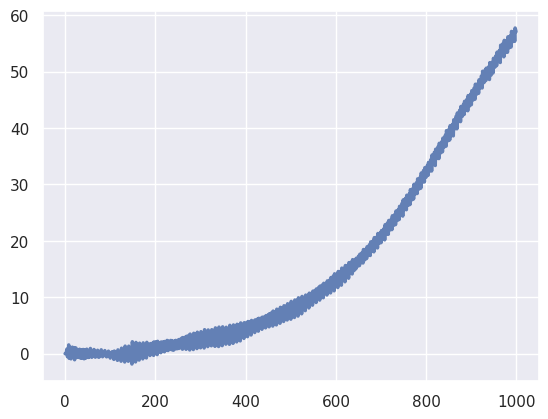

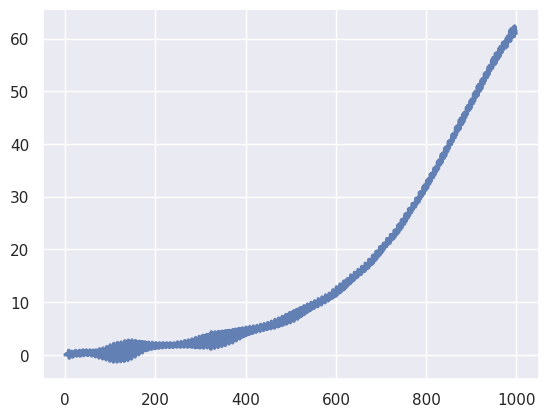

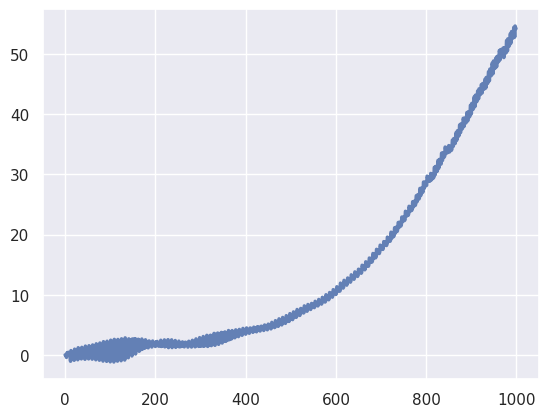

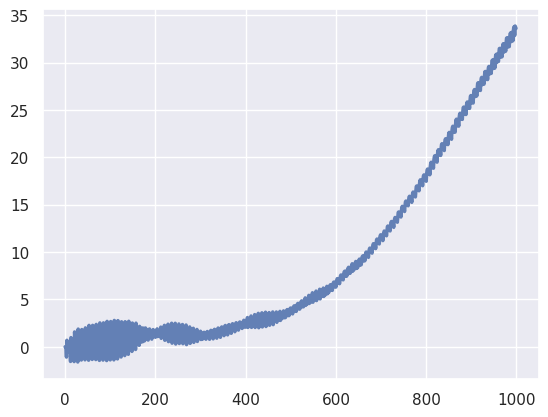

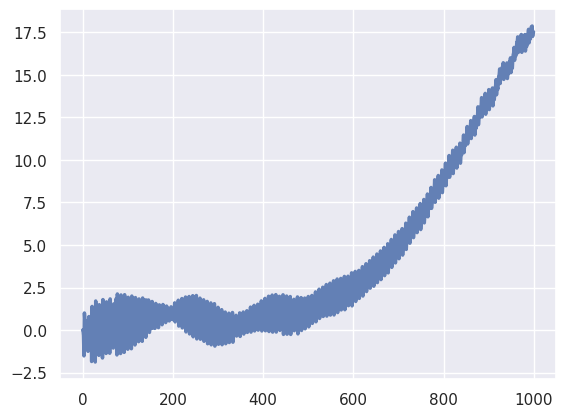

In [38]:
# -jp.pi
# rewards, rollout = eval_with_injury(policy, env, obs_normalizer, best_params, obs_params, target=None, injury=False)
# rewards, rollout = eval_with_injury(policy, env, obs_normalizer, best_params, obs_params, target={train_task.task_kwargs: 1.}, injury=False)
for i in range(12):
    print('{} / 12'.format(i))
    target = (1 - i / 12) * train_task.task_min + i / 12 * train_task.task_max
    meta_rewards, meta_rollout = rewards, rollout = eval_with_injury(policy, env, obs_normalizer, best_params, obs_params, target={train_task.task_kwargs: target}, injury=False)

#### Base

In [19]:
def eval_with_injury_base(policy, env_name, obs_normalizer, params, obs_params, target=None, injury=False, plot=True):
    # def step_once(carry, input_data):
    #     (task_state, policy_state, params, obs_params,
    #      accumulated_reward) = carry
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
    #     act, policy_state = act_fn(task_state, params[None, :], policy_state)
    #     task_state = task_state.replace(obs=task_state.obs[0])
    #     task_state = env.step(task_state, act[0])
    #     policy_state = update_fn(params[None, :], policy_state, None)
    #     accumulated_reward = accumulated_reward + task_state.reward
    #
    #     return ((task_state, policy_state, params, obs_params, accumulated_reward), (task_state))
    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    rng = jax.random.PRNGKey(42 + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)

    # accumulated_rewards = jnp.zeros((1, ))
    # task_states = jax.lax.scan(
    #     step_once,
    #     (task_state, policy_state, params, obs_params, accumulated_rewards),
    #     (), 1000
    # )
    # print(task_states)

    step = 0
    while not task_state.done:
        rollout.append(task_state)
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.
        if step > 500 and step < 550 and injury:
            params *= 0
            # policy_state.fast_Ws[1] *= 0

        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = step_fn(task_state, act)
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws') and step % 10 == 0:
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    if plot:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = np.array(jnp.concatenate(w)[jnp.newaxis, :, jnp.newaxis, :, :])
            # TODO: w

        html.save_html(os.path.join(output_dir, 'eval_with_injury_{}.html'.format(target)), env.sys, [s.qp for s in rollout])

        fig, ax = plt.subplots()
        ax.plot(rewards)
        plt.savefig(os.path.join(output_dir, 'BraxMetaLearning_{}.pdf').format(target))

    return rewards, rollout

In [13]:
env = 'halfcheetah_vel'
num_tasks = 8
hidden_dims = [128]
resume = '/data/floyed/meta/train/PGPE-MLPSnnPolicy-halfcheetah_vel--20230622-113532'

train_task = BraxTask(
    env_name=env,
    test=False,
    num_tasks=num_tasks
    # terminate_when_unhealthy=args.terminate_when_unhealthy
)
policy = getattr(evojax.policy, 'MLPSnnPolicy')(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[
        *hidden_dims,
    ],
    output_dim=train_task.act_shape[0],
)

best_params, obs_params, epoch, best_score, steps = load_model(model_dir=resume)
obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

(19,) (6,)


MLPPolicy: 2023-06-23 00:37:45,400 [INFO] MLPPolicy.num_params = 3334


(19,)


(1, 1) (1, 18)
[Eval with injury] 100, reward:-2.131e+02
[Eval with injury] 200, reward:-3.825e+02
[Eval with injury] 300, reward:-5.639e+02
[Eval with injury] 400, reward:-7.315e+02
[Eval with injury] 500, reward:-8.906e+02
[Eval with injury] 600, reward:-1.332e+03
[Eval with injury] 700, reward:-1.834e+03
[Eval with injury] 800, reward:-2.335e+03
[Eval with injury] 900, reward:-2.836e+03
[Eval with injury] 1000, reward:-3.337e+03
[Eval with injury] rollout reward = -3336.85546875


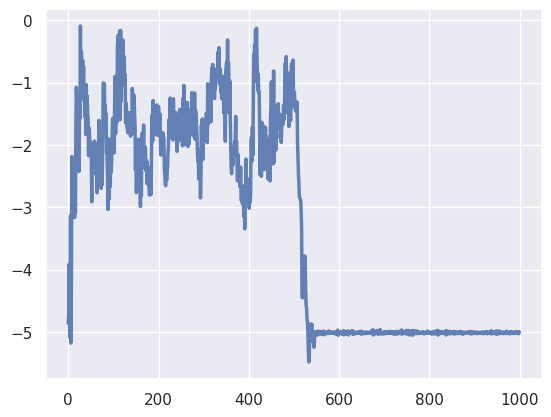

In [14]:
# -jp.pi
eval_with_injury_base(policy, env, obs_normalizer, best_params, obs_params, target={train_task.task_kwargs: 5.}, injury=True)

### Test Generalizability

In [39]:
# env = 'ant_dir'  # halfcheetah_vel
num_tasks = 8
hidden_dims = [128]
resume_meta = [
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211',
    # '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230622-192221',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230624-095727',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-halfcheetah_vel-ABCD-20230622-192203',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-hopper_vel-ABCD-20230622-192225',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-fetch-ABCD-20230622-212210',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ur5e-ABCD-20230622-192216',
]

resume_base = [
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ant_dir--20230622-113608',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-swimmer_dir--20230622-113637',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-halfcheetah_vel--20230622-113532',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-hopper_vel--20230622-113649',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-fetch--20230622-132230',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ur5e--20230622-113621',
]
env_names = ['ant_dir',  'swimmer_dir', 'halfcheetah_vel', 'hopper_vel', 'fetch', 'ur5e']

xs, y_metas, y_bases = [], [], []
for idx, env in enumerate(env_names):
    # resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230620-213437'
    # resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230614-220747'
    # resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211'
    # resume = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-halfcheetah_vel-ABCD-20230614-220745'
    print(env)
    train_task = BraxTask(
        env_name=env,
        test=False,
        num_tasks=num_tasks
        # terminate_when_unhealthy=args.terminate_when_unhealthy
    )
    policy_meta = getattr(evojax.policy, 'MetaStdpMLPPolicy')(
        input_dim=train_task.obs_shape[0],
        hidden_dims=[
            *hidden_dims,
        ],
        output_dim=train_task.act_shape[0],
    )

    policy_base = getattr(evojax.policy, 'MLPSnnPolicy')(
        input_dim=train_task.obs_shape[0],
        hidden_dims=[
            *hidden_dims,
        ],
        output_dim=train_task.act_shape[0],
    )

    meta_best_params, meta_obs_params, meta_epoch, meta_best_score, meta_steps = load_model(model_dir=resume_meta[idx])
    base_best_params, base_obs_params, base_epoch, base_best_score, base_steps = load_model(model_dir=resume_base[idx])
    meta_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)
    base_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

    x, y_meta, y_base = [], [], []
    if env in ['fetch', 'ur5e']:
        meta_rewards, meta_rollout = \
            eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target=None, injury=False, plot=False)
        base_rewards, base_rollout = \
            eval_with_injury_base(policy_base, env, base_obs_normalizer, base_best_params, base_obs_params, target=None, injury=False, plot=False)
        x.append([0])
        y_meta.append(meta_rewards)
        y_base.append(base_rewards)

    else:
        for i in range(72):
            print('{} / 72'.format(i))
            _min = train_task.task_min + (train_task.task_max - train_task.task_min) / 8
            _max = train_task.task_max - (train_task.task_max - train_task.task_min) / 8
            target = (1 - i / 72) * train_task.task_min + i / 72 * train_task.task_max
            _target = (1 - i / 72) * _min + i / 72 * _max
            meta_rewards, meta_rollout = \
                eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target={train_task.task_kwargs: _target}, injury=False, plot=False)
            base_rewards, base_rollout = \
                eval_with_injury_base(policy_base, env, base_obs_normalizer, base_best_params, base_obs_params, target={train_task.task_kwargs: _target}, injury=False, plot=False)
            x.append(target)
            y_meta.append(sum(meta_rewards))
            y_base.append(sum(base_rewards))

    xs.append(x)
    y_metas.append(y_meta)
    y_bases.append(y_base)

ant_dir


MLPPolicy: 2023-06-24 17:05:10,946 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)
(28,)
(28,)
0 / 72
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5276.5439453125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 992.3375244140625
1 / 72
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5328.2880859375
(1, 1) (1, 27)
[Eval with injury] rollout reward = 992.4791870117188
2 / 72
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5304.2421875
(1, 1) (1, 27)
[Eval with injury] rollout reward = 992.156005859375
3 / 72
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5273.88720703125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 996.326171875
4 / 72
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5268.14697265625
(1, 1) (1, 27)
[Eval with injury] rollout reward = 995.6050415039062
5 / 72
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5297.8095703125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 995.66650390625
6 / 72
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5316.27978515625
(1, 1) (1, 27)
[Eval with injury] rollout reward = 9

MLPPolicy: 2023-06-24 17:28:29,255 [INFO] MLPPolicy.num_params = 1538


(9,) (2,)
(9,)
(9,)
0 / 72
(1, 1) (1, 8)
[Eval with injury] rollout reward = 6718.439453125
(1, 1) (1, 8)
[Eval with injury] rollout reward = 71.41179656982422
1 / 72
(1, 1) (1, 8)
[Eval with injury] rollout reward = 7320.70068359375
(1, 1) (1, 8)
[Eval with injury] rollout reward = 69.84249114990234
2 / 72
(1, 1) (1, 8)
[Eval with injury] rollout reward = 8044.537109375
(1, 1) (1, 8)
[Eval with injury] rollout reward = 67.1768798828125
3 / 72
(1, 1) (1, 8)
[Eval with injury] rollout reward = 8795.9970703125
(1, 1) (1, 8)
[Eval with injury] rollout reward = 65.42288208007812
4 / 72
(1, 1) (1, 8)
[Eval with injury] rollout reward = 9382.5185546875
(1, 1) (1, 8)
[Eval with injury] rollout reward = 40.758026123046875
5 / 72
(1, 1) (1, 8)
[Eval with injury] rollout reward = 10163.8232421875
(1, 1) (1, 8)
[Eval with injury] rollout reward = 19.672550201416016
6 / 72
(1, 1) (1, 8)
[Eval with injury] rollout reward = 10755.578125
(1, 1) (1, 8)
[Eval with injury] rollout reward = 6.72309207916

MLPPolicy: 2023-06-24 17:41:08,672 [INFO] MLPPolicy.num_params = 3334


(19,) (6,)
(19,)
(19,)
0 / 72
(1, 1) (1, 18)
[Eval with injury] rollout reward = -210.81076049804688
(1, 1) (1, 18)
[Eval with injury] rollout reward = -280.9963073730469
1 / 72
(1, 1) (1, 18)
[Eval with injury] rollout reward = -217.5007781982422
(1, 1) (1, 18)
[Eval with injury] rollout reward = -337.4419250488281
2 / 72
(1, 1) (1, 18)
[Eval with injury] rollout reward = -308.7626037597656
(1, 1) (1, 18)
[Eval with injury] rollout reward = -292.24957275390625
3 / 72
(1, 1) (1, 18)
[Eval with injury] rollout reward = -360.25732421875
(1, 1) (1, 18)
[Eval with injury] rollout reward = -370.5157775878906
4 / 72
(1, 1) (1, 18)
[Eval with injury] rollout reward = -432.80206298828125
(1, 1) (1, 18)
[Eval with injury] rollout reward = -393.028076171875
5 / 72
(1, 1) (1, 18)
[Eval with injury] rollout reward = -484.93707275390625
(1, 1) (1, 18)
[Eval with injury] rollout reward = -530.5087890625
6 / 72
(1, 1) (1, 18)
[Eval with injury] rollout reward = -408.81658935546875
(1, 1) (1, 18)
[Eva

MLPPolicy: 2023-06-24 18:02:28,578 [INFO] MLPPolicy.num_params = 2051


(12,) (3,)
(12,)
(12,)
0 / 72
(1, 1) (1, 11)
[Eval with injury] rollout reward = 972.3192138671875
(1, 1) (1, 11)
[Eval with injury] rollout reward = 948.226318359375
1 / 72
(1, 1) (1, 11)
[Eval with injury] rollout reward = 970.5274047851562
(1, 1) (1, 11)
[Eval with injury] rollout reward = 952.3864135742188
2 / 72
(1, 1) (1, 11)
[Eval with injury] rollout reward = 960.1448974609375
(1, 1) (1, 11)
[Eval with injury] rollout reward = 942.4208984375
3 / 72
(1, 1) (1, 11)
[Eval with injury] rollout reward = 947.514404296875
(1, 1) (1, 11)
[Eval with injury] rollout reward = 931.7925415039062
4 / 72
(1, 1) (1, 11)
[Eval with injury] rollout reward = 937.3410034179688
(1, 1) (1, 11)
[Eval with injury] rollout reward = 922.3281860351562
5 / 72
(1, 1) (1, 11)
[Eval with injury] rollout reward = 933.3665771484375
(1, 1) (1, 11)
[Eval with injury] rollout reward = 912.3126831054688
6 / 72
(1, 1) (1, 11)
[Eval with injury] rollout reward = 926.049560546875
(1, 1) (1, 11)
[Eval with injury] rol

MLPPolicy: 2023-06-24 18:21:19,429 [INFO] MLPPolicy.num_params = 14346


(101,) (10,)
(101,)
(101,)
(1, 0) (1, 101)
[Eval with injury] rollout reward = 62.750938415527344
(1, 0) (1, 101)
[Eval with injury] rollout reward = 11.805059432983398
ur5e


MLPPolicy: 2023-06-24 18:21:40,878 [INFO] MLPPolicy.num_params = 9350


(66,) (6,)
(66,)
(66,)
(1, 0) (1, 66)
[Eval with injury] rollout reward = 109.0873794555664
(1, 0) (1, 66)
[Eval with injury] rollout reward = 5.2074174880981445


In [40]:
# env = 'ant_dir'
# num_tasks = 8
# hidden_dims = [128]
# # resume = '/data/floyed/meta/train/PGPE-MLPSnnPolicy-halfcheetah_vel--20230622-113532'
# resume = '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ant_dir--20230622-113608'
#
# train_task = BraxTask(
#     env_name=env,
#     test=False,
#     num_tasks=num_tasks
#     # terminate_when_unhealthy=args.terminate_when_unhealthy
# )
# policy = getattr(evojax.policy, 'MLPSnnPolicy')(
#     input_dim=train_task.obs_shape[0],
#     hidden_dims=[
#         *hidden_dims,
#     ],
#     output_dim=train_task.act_shape[0],
# )

MLPPolicy: 2023-06-24 18:31:07,367 [INFO] MLPPolicy.num_params = 4744


(28,) (8,)


In [54]:
# y_base = []
# for _x in x:
#     print('{} / 72'.format(_x))
#     rewards, rollout = eval_with_injury_base(policy, env, obs_normalizer, best_params, obs_params, target={train_task.task_kwargs: _x}, injury=False, plot=False)
#     y_base.append(sum(rewards))

-3.141592653589793 / 72
[Eval with injury] 100, reward:-1.319e+02
[Eval with injury] 200, reward:-2.545e+02
[Eval with injury] 300, reward:-3.378e+02
[Eval with injury] 400, reward:-4.941e+02
[Eval with injury] 500, reward:-6.298e+02
[Eval with injury] 600, reward:-7.057e+02
[Eval with injury] 700, reward:-8.425e+02
[Eval with injury] 800, reward:-1.011e+03
[Eval with injury] 900, reward:-1.115e+03
[Eval with injury] 1000, reward:-1.206e+03
[Eval with injury] rollout reward = -1205.67626953125
-3.0543261909900767 / 72
[Eval with injury] 100, reward:-1.756e+02
[Eval with injury] 200, reward:-2.816e+02
[Eval with injury] 300, reward:-4.520e+02
[Eval with injury] 400, reward:-6.048e+02
[Eval with injury] 500, reward:-7.669e+02
[Eval with injury] 600, reward:-8.657e+02
[Eval with injury] 700, reward:-9.944e+02
[Eval with injury] 800, reward:-1.123e+03
[Eval with injury] 900, reward:-1.272e+03
[Eval with injury] 1000, reward:-1.422e+03
[Eval with injury] rollout reward = -1421.7967529296875

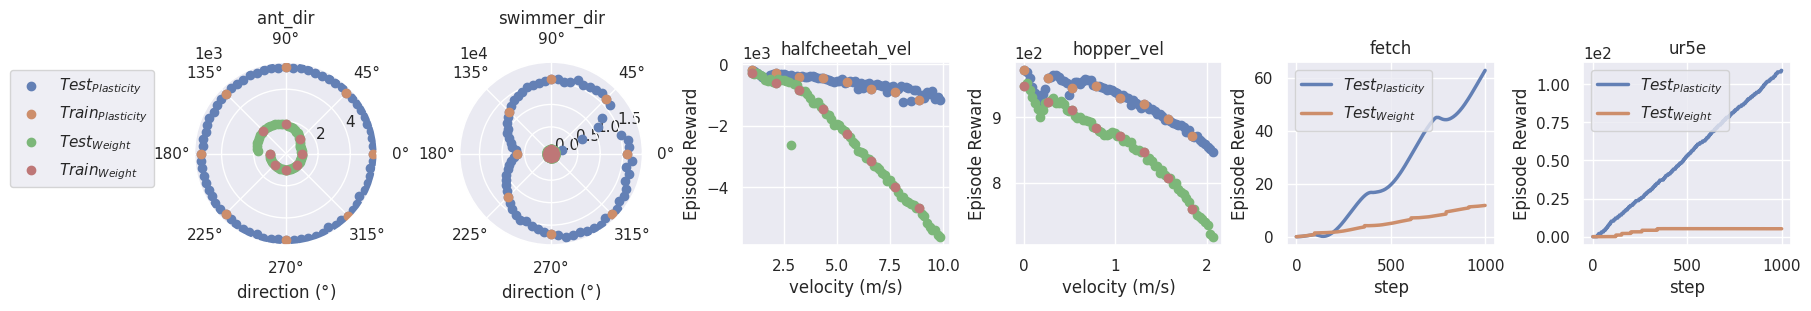

In [76]:
fig = plt.figure(figsize=(18, 3), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=1, ncols=6, figure=fig)  #, width_ratios=[.2, 1, 1, 1, 1, .08, 1.6], height_ratios=[0.02, 1, 1, 0.01])

xlabels = ['direction ($\degree$)', 'direction ($\degree$)', 'velocity (m/s)', 'velocity (m/s)', 'step', 'step']
ylabels = ['', '', 'Episode Reward', 'Episode Reward', 'Episode Reward', 'Episode Reward']

for idx, env in enumerate(env_names):

    x = xs[idx]
    y_meta = y_metas[idx]
    y_base = y_bases[idx]


    if idx in [0, 1]:
        ax = fig.add_subplot(spec[0, idx], projection='polar')
    else:
        ax = fig.add_subplot(spec[0, idx])

    if idx in [0, 1, 2, 3]:
        xx = x[::9]
        yy_meta = y_meta[::9]
        yy_base = y_base[::9]

        plt.scatter(x, y_meta)
        plt.scatter(xx, yy_meta)
        plt.scatter(x, y_base)
        plt.scatter(xx, yy_base)

        # plt.ylim(0, 6000)
        # plt.legend(['$Test_{Plasticity}$', '$Train_{Plasticity}$', '$Test_{Weight}$', '$Train_{Weight}$'])
        if idx == 0:
            plt.legend(labels=['$Test_{Plasticity}$', '$Train_{Plasticity}$', '$Test_{Weight}$', '$Train_{Weight}$'], loc=2, bbox_to_anchor=(-1.05,1))
    else:
        y_meta = np.array(list(y_meta)).reshape(-1)
        y_base = np.array(list(y_base)).reshape(-1)
        plt.plot(np.cumsum(y_meta))
        plt.plot(np.cumsum(y_base))
        plt.legend(['$Test_{Plasticity}$', '$Test_{Weight}$'])

    ax.set_xlabel(xlabels[idx])
    ax.set_ylabel(ylabels[idx])
    ax.set_title(env)
    ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

plt.savefig(os.path.join(output_dir, 'generalize.pdf'), format='pdf', bbox_inches='tight')
plt.show()